Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

🚀 MEMULAI PELATIHAN MODEL DNN...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8207/8207 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.5099 - loss: 0.9578 - val_accuracy: 0.5374 - val_loss: 0.9287
Epoch 2/100
8207/8207 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.5377 - loss: 0.9294 - val_accuracy: 0.5494 - val_loss: 0.9162
Epoch 3/100
8207/8207 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.5490 - loss: 0.9153 - val_accuracy: 0.5567 - val_loss: 0.9045
Epoch 4/100
8207/8207 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.5592 - loss: 0.9025 - val_accuracy: 0.5635 - val_loss: 0.8962
Epoch 5/100
8207/8207 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.5673 - loss: 0.8924 - val_accuracy: 0.5692 - val_loss: 0.8886
Epoch 6/100
8207/8207 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.5725 - loss: 0.8851 - val_accuracy: 0.5760 - val_loss: 0.8798
Epoch 7/100
8207/8207 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.5772 - loss: 0.8791 - val_accuracy: 0.5796 - val_loss: 0.8749
Epoch 8/100
8207/8207 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.5799 - loss: 0.873

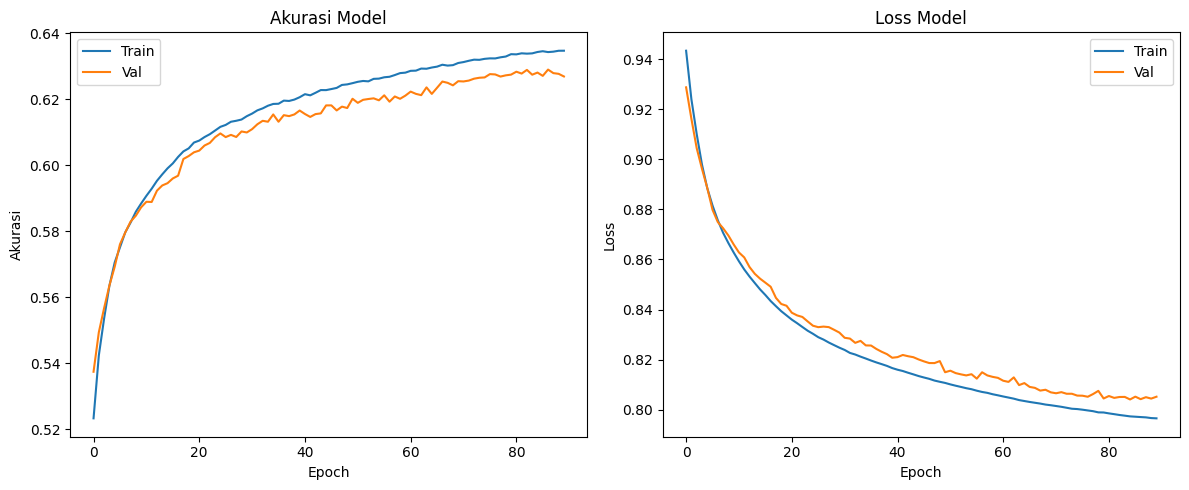

/tmp/ipython-input-3-3971240764.py:167: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3-3971240764.py:176: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


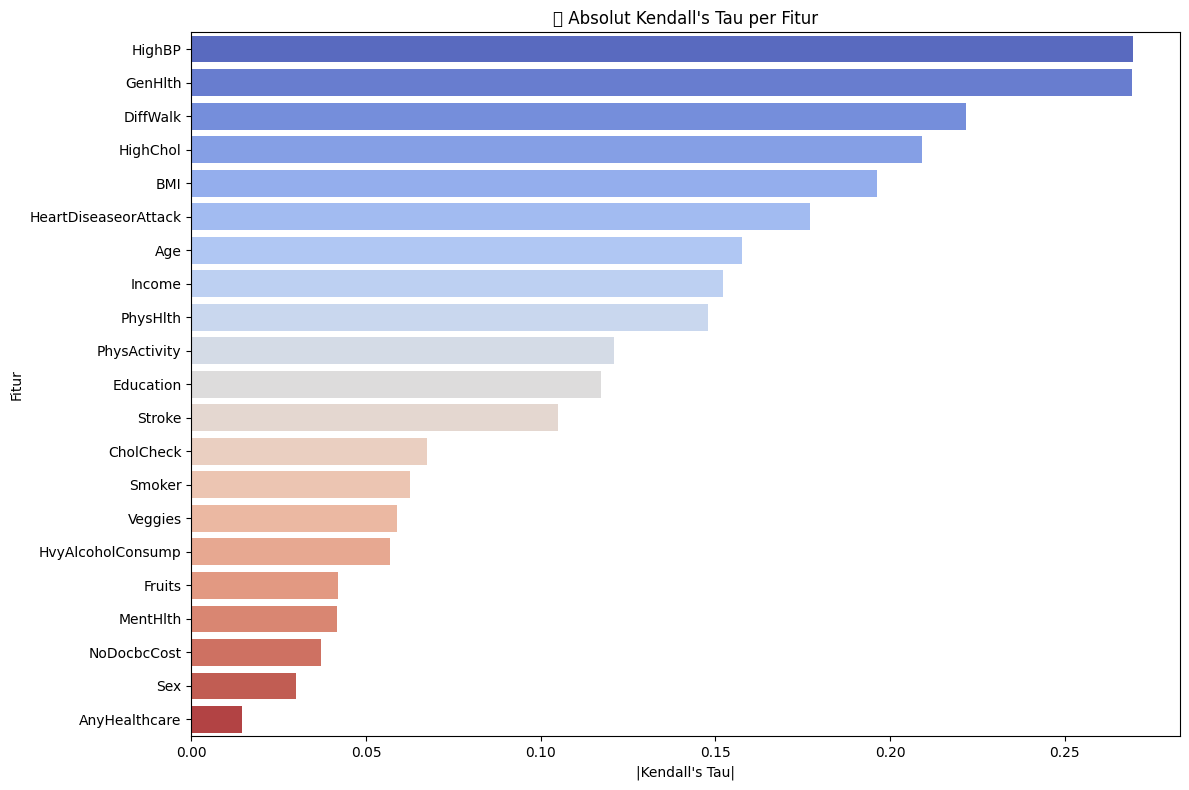

In [ ]:
# ========================================
# IMPORT LIBRARY & SET SEED
# ========================================
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats import kendalltau
from scipy.stats.mstats import winsorize
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Seed untuk reproducibility
SEED = 44
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# ========================================
# LOAD & PREPROCESS DATA
# ========================================
from google.colab import drive
drive.mount('/content/drive')

# Load data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Skripsi/Dataset/diabetes_012_health_indicators_BRFSS2015.csv')
X = data.drop('Diabetes_012', axis=1)
y = data['Diabetes_012']

# Winsorizing dan capping
X['BMI'] = winsorize(X['BMI'], limits=[0.005, 0.005])
X['MentHlth'] = np.where(X['MentHlth'] > 30, 30, X['MentHlth'])
X['PhysHlth'] = np.where(X['PhysHlth'] > 30, 30, X['PhysHlth'])

# Scaling
robust_features = ['BMI', 'MentHlth', 'PhysHlth']
minmax_features = ['Age', 'Education', 'Income', 'GenHlth']

scaler_robust = RobustScaler()
scaler_minmax = MinMaxScaler()

X[robust_features] = scaler_robust.fit_transform(X[robust_features])
X[minmax_features] = scaler_minmax.fit_transform(X[minmax_features])

# ========================================
# KENDALL'S CORRELATION FEATURE SELECTION
# ========================================
kendall_results = []
for feature in X.columns:
    tau, p = kendalltau(X[feature], y)
    kendall_results.append({
        'Feature': feature,
        'Kendall_Tau': tau,
        'Abs_Kendall_Tau': abs(tau),
        'P_Value': p
    })

kendall_df = pd.DataFrame(kendall_results)
kendall_df_sorted = kendall_df.sort_values(by='Abs_Kendall_Tau', ascending=False)

mean_abs_tau = kendall_df['Abs_Kendall_Tau'].mean()
top_features = kendall_df[kendall_df['Abs_Kendall_Tau'] >= mean_abs_tau]['Feature'].tolist()

# ========================================
# SPLIT DATA SEBELUM SMOTE (anti data leakage)
# ========================================
X_top = X[top_features]

X_train, X_test, y_train, y_test = train_test_split(
    X_top, y, test_size=0.2, random_state=SEED, stratify=y
)

# SMOTE hanya pada training set
smote = SMOTE(random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# One-hot encoding setelah SMOTE
y_train_encoded = to_categorical(y_train_resampled)
y_test_encoded = to_categorical(y_test)

# Split training menjadi train dan val
X_train_main, X_val, y_train_main, y_val = train_test_split(
    X_train_resampled, y_train_encoded, test_size=0.2, random_state=SEED,
    stratify=y_train_encoded.argmax(axis=1)
)

# ========================================
# BANGUN DAN LATIH MODEL
# ========================================
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_top.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\n🚀 MEMULAI PELATIHAN MODEL DNN...")
history = model.fit(
    X_train_main, y_train_main,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=50,
    callbacks=[early_stop],
    verbose=1
)

# ========================================
# EVALUASI MODEL
# ========================================
y_pred_prob = model.predict(X_test, verbose=0)
y_pred_class = np.argmax(y_pred_prob, axis=1)
y_true_class = np.argmax(y_test_encoded, axis=1)

print("\n=== 📋 CLASSIFICATION REPORT ===")
print(classification_report(y_true_class, y_pred_class, digits=4))

roc_auc = roc_auc_score(y_test_encoded, y_pred_prob, average='macro', multi_class='ovr')
print(f"\n📈 ROC AUC (Macro Average): {roc_auc:.4f}")

# ========================================
# VISUALISASI AKURASI & LOSS
# ========================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ========================================
# VISUALISASI KENDALL'S TAU
# ========================================
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Abs_Kendall_Tau',
    y='Feature',
    data=kendall_df_sorted,
    palette='coolwarm'
)
plt.title("🔍 Absolut Kendall's Tau per Fitur")
plt.xlabel('|Kendall\'s Tau|')
plt.ylabel('Fitur')
plt.tight_layout()
plt.show()
